## Install GRASS

> Note: This step may take a few minutes depending on your internet connection.

In [1]:
%%bash

apt-get install grass grass-dev grass-doc
# leave the directory with source code
cd ~

# download sample data
mkdir -p grassdata
curl -SL https://grass.osgeo.org/sampledata/north_carolina/nc_spm_08_grass7.zip > nc_spm_08_grass7.zip
unzip -qq nc_spm_08_grass7.zip
mv nc_spm_08_grass7 grassdata
rm nc_spm_08_grass7.zip


Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fakeroot fonts-dejavu-core fonts-droid-fallback fonts-lyx fonts-noto-mono fonts-urw-base35
  freeglut3 gdal-bin ghostscript grass-core grass-gui libfakeroot libfftw3-double3 libfontenc1
  libglu1-mesa libgs9 libgs9-common libidn12 libijs-0.35 libimagequant0 libjbig2dec0 liblbfgsb0
  libnotify4 libraqm0 libwxbase3.0-0v5 libwxgtk3.0-gtk3-0v5 libxkbfile1 libxsimd-dev libxtst6
  libxxf86dga1 mailcap mime-support poppler-data proj-bin python-matplotlib-data python3-appdirs
  python3-attr python3-beniget python3-brotli python3-bs4 python3-chardet python3-cycler
  python3-dateutil python3-decorator python3-fonttools python3-fs python3-gast python3-gdal
  python3-html5lib python3-kiwisolver python3-lxml python3-lz4 python3-matplotlib python3-mpmath
  python3-numpy python3-olefile python3-opengl python3-packaging python3-pil python3-pil.imagetk
  python3-ply p

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  140M  100  140M    0     0  29.8M      0  0:00:04  0:00:04 --:--:-- 35.1M


### Download input data

In [2]:
%%bash

# Make input directory and download inputs data
mkdir -p inputs

BASE_DOWNLOAD_URL=https://raw.githubusercontent.com/ncsu-geoforall-lab/GIS582-assignments/main/7AB%20-%20Flow%20Modeling/inputs/
FILENAMES="cfac_color,cfac_rules,erdep_class,erdep_color,erdep_label,land_to_mannings,land_to_rain,lu_labels,outlet_point,soilloss_color"

# Convert the comma-separated string to an array
IFS=',' read -r -a filename_array <<< "$FILENAMES"

# Loop through each URL in the array
for filename in "${filename_array[@]}"
do
    echo "Downloading: $filename"
    # Use curl to download each file
    # The '-O' option saves the file with its original name
    curl $BASE_DOWNLOAD_URL${filename}.txt --output ./inputs/${filename}.txt || echo "Failed to download: $url"
done

echo "Download completed."

Downloading: cfac_color
Downloading: cfac_rules
Downloading: erdep_class
Downloading: erdep_color
Downloading: erdep_label
Downloading: land_to_mannings
Downloading: land_to_rain
Downloading: lu_labels
Downloading: outlet_point
Downloading: soilloss_color
Download completed.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    57  100    57    0     0    310      0 --:--:-- --:--:-- --:--:--   311
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   147  100   147    0     0    894      0 --:--:-- --:--:-- --:--:--   896
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   107  100   107    0     0    634      0 --:--:-- --:--:-- --:--:--   636
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   172  100   172    0     0   1015      0 --:--:-- --:--:-- --:--:--  1011
  % Total    % Received % Xferd  Average Speed   Tim

Create the `output` directory to save your maps.

In [3]:
%%bash
mkdir -p output

## Start GRASS GIS

Create a new mapset to run your analysis.

In [4]:
%%bash
grass -e -c ~/grassdata/nc_spm_08_grass7/HW_7A_Flow_Modeling

Creating new GRASS GIS mapset <HW_7A_Flow_Modeling>...


We are now setting up our python environment so we can visualize our data with GRASS Jupyter.

In [5]:
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.
# FOR WINDOWS:
# grass_call = "grass80"
# shell_setting = True
# FOR MAC/LINUX
grass_call = "grass"
shell_setting = False

sys.path.append(
    subprocess.check_output([grass_call, "--config", "python_path"], text=True, shell=shell_setting).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
gj.init("~/grassdata/nc_spm_08_grass7/HW_7A_Flow_Modeling")


## Compute flow direction, flow accumulation and subwatersheds

Compute flow direction, flow accumulation and subwatersheds with approx. size of 10000 cells from 30m NED.

In [6]:
%%bash
g.region raster=elev_ned_30m -p
r.watershed -s elevation=elev_ned_30m threshold=10000 accumulation=accum_10K drainage=draindir_10K basin=basin_10K --quiet

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      30
ewres:      30
rows:       450
cols:       500
cells:      225000


Extract more detailed streams from flow accumulation raster:

In [7]:
%%bash

r.mapcalc "streams_der_30m = if(abs(accum_10K) > 100, 1, null())"

Convert to vector format and display results along with the official Wake county streams (red):

In [8]:
%%bash
r.to.vect -s basin_10K output=basin_10K type=area --quiet
r.thin streams_der_30m output=streams_der_30m_t --quiet
r.to.vect -s streams_der_30m_t out=streams_der_30m type=line --quiet

Generate shaded map and display:

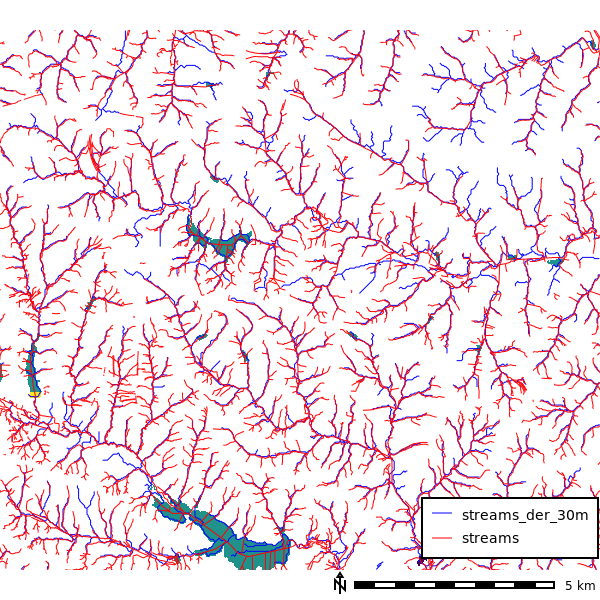

In [9]:
# Create Map instance
mystream_map = gj.Map(height=600, width=600, filename="output/mystream.png")
# Add the elevation raster to the map
mystream_map.d_rast(map="lakes")
mystream_map.d_vect(map="streams_der_30m", color="blue")
mystream_map.d_vect(map="streams", color="red")
mystream_map.d_legend_vect(at=[72,17], flags="b")
mystream_map.d_barscale(at=[55,5], flags="n")

# Display map
mystream_map.show()

<div class="alert alert-block alert-info">
    
### Question: How do the derived streams compare with the official stream map?

Derived streams are more detailed compared to the official streams. Looking in places where both red and blue lines have some overlap, the red (official streams) lines are straighter and often shorter in length. The blue (Derived streams) lines appear more squiggly meaning these stream lines have higher detail than the official stream lines. The derived streams pretty often extend past the official stream lines and also occur in areas where there's no official stream line visible.

<div class="alert alert-block alert-info">

### Task: Modify the mapcalc expression to make stream origins fit better with the official stream map.

In [62]:
%%bash

r.mapcalc "streams_der_30m = if(abs(accum_10K) > 140, 1, null())"

# Original expression: r.mapcalc "streams_der_30m = if(abs(accum_10K) > 100, 1, null())"

In [63]:
%%bash
r.to.vect -s basin_10K output=basin_10K type=area --quiet
r.thin streams_der_30m output=streams_der_30m_t --quiet
r.to.vect -s streams_der_30m_t out=streams_der_30m type=line --quiet

         overwritten


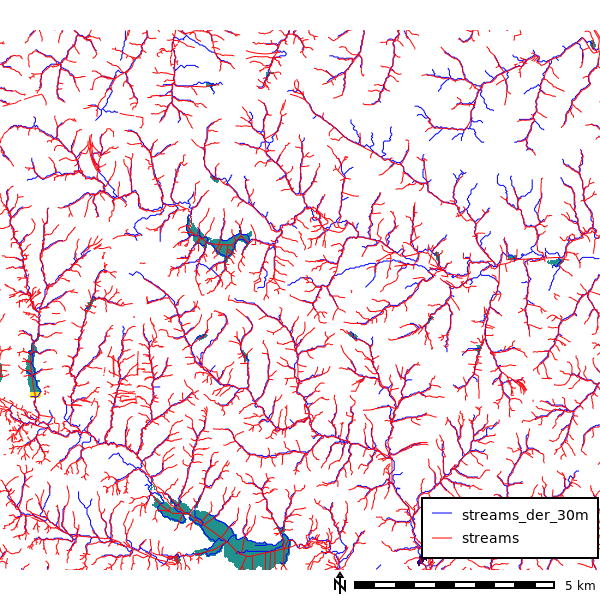

In [64]:
# Create Map instance
mystream_map1 = gj.Map(height=600, width=600, filename="output/mystream1.png")
# Add the elevation raster to the map
mystream_map1.d_rast(map="lakes")
mystream_map1.d_vect(map="streams_der_30m", color="blue")
mystream_map1.d_vect(map="streams", color="red")
mystream_map1.d_legend_vect(at=[72,17], flags="b")
mystream_map1.d_barscale(at=[55,5], flags="n")

# Display map
mystream_map1.show()

<div class="alert alert-block alert-info">

### Question: Why does your modification make the stream orgins fit better with the offical stream map?

Increasing the range of values to include from 100 to 140 starts to simplify the stream layer to make it more similar to the official streams layer. However, increasing this value too much will result in oversimplification to where the official stream layer then is the more detailed layer.

## Create map of DEM depressions

Depression filling is often necessary for certain flow routing algorithms but it can alter the elevation data significantly. Find out how extensive the depressions are in our DEM. \

> Note that [r.watershed](https://grass.osgeo.org/grass83/manuals/r.watershed.html) doesn't need any depression filling thanks to its underlying algorithm which uses least cost path to get over depressions.

In [65]:
%%bash
g.region raster=elevation -p
r.fill.dir input=elevation output=elev_fill1 direction=dir1 areas=unres1
r.fill.dir input=elev_fill1 output=elev_fill2 direction=dir2 areas=unres2
r.fill.dir input=elev_fill2 output=elev_fill3 direction=dir3 areas=unres3
r.mapcalc "depr_bin = if((elevation-elev_fill3) < 0., 1, null())"
r.colors depr_bin color=blues

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      10
ewres:      10
rows:       1350
cols:       1500
cells:      2025000


Reading input elevation raster map...
   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  60%  63%  66%  69%  72%  75%  78%  81%  84%  87%  90%  93%  96%  99% 100%
Filling sinks...
Determining flow directions for ambiguous cases...
Found 7944 unresolved areas
Repeat to get the final directions...
Found 1013 unresolved areas
Writing output raster maps...
   0%   6%  12%  18%  24%  30%  36%  42%  48%  54%  60%  66%  72%  78%  84%  90%  96% 100%
Reading input elevation raster map...
   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%

Display the new results, compare the derived depressions with actual lakes:

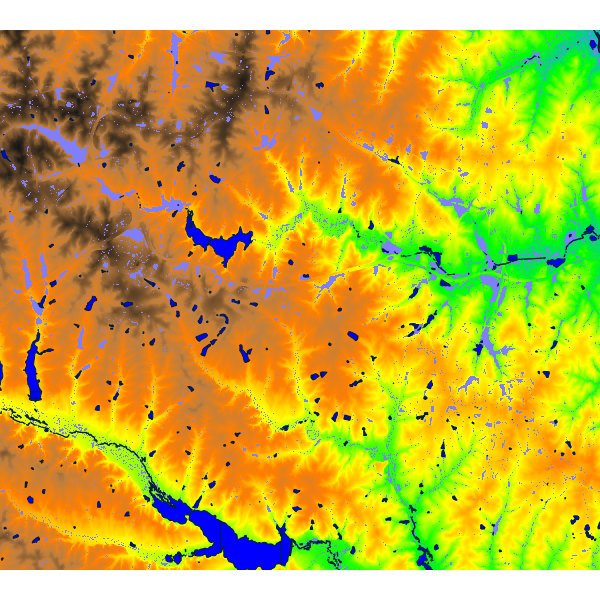

In [66]:
# Create Map instance
depressions_map = gj.Map(height=600, width=600, filename="output/depressions.png")
# Add the elevation raster to the map
depressions_map.d_rast(map="elevation")
depressions_map.d_rast(map="depr_bin")
depressions_map.d_vect(map="lakes", fill_color="blue", type="area")

# Display map
depressions_map.show()

## Derive contributing area for a given outlet

Set region to the high resolution study area and zoom to it:

In [67]:
%%bash
g.region rural_1m -p
r.watershed -as elevation=elev_lid792_1m threshold=5000 accumulation=accum_5K drainage=draindir_5K basin=basin_5K --quiet

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


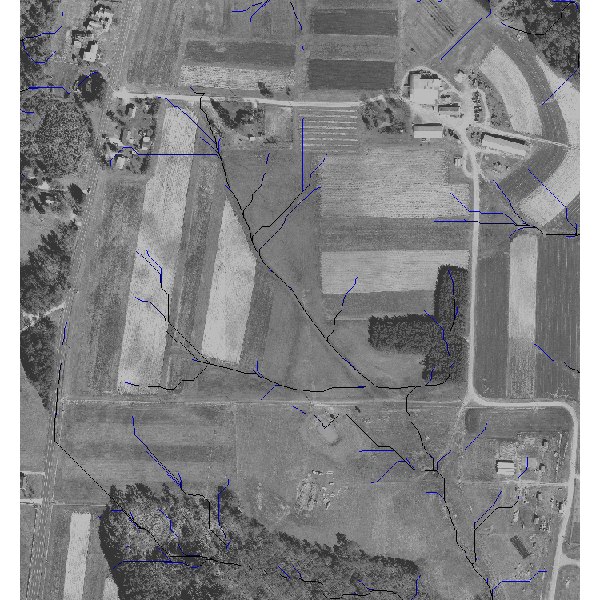

In [68]:
# Create Map instance
accum_5K_map = gj.Map(height=600, width=600, use_region=True)
# Add the elevation raster to the map
accum_5K_map.d_rast(map="ortho_2001_t792_1m")
accum_5K_map.d_rast(map="accum_5K", values="1500-1000000")

# Display map
accum_5K_map.show()

Identify outlet on the extracted stream.

Create a vector map with the point east=638845.52 north=220085.26 that has accum_5K=224510.

In [69]:
%%bash
v.in.ascii ./inputs/outlet_point.txt output=outletA30 separator=space

Scanning input for column types...
Number of columns: 3
Number of data rows: 1
Importing points...
   0% 100%
Populating table...
Building topology for vector map <outletA30@HW_7A_Flow_Modeling>...
Registering primitives...


Display the outlet on the map.

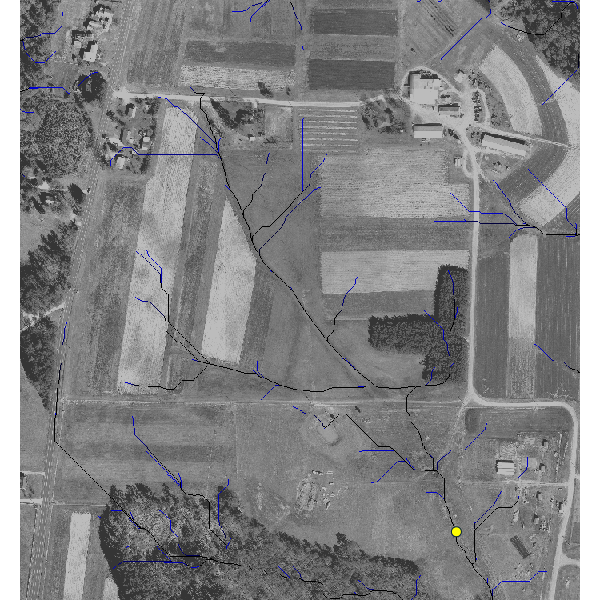

In [70]:
accum_5K_map.d_vect(map="outletA30", fill_color="yellow", type="point", icon="basic/circle", size=10)
accum_5K_map.show()

Delineate the contributing area associated with this outlet and convert it to vector format:

In [71]:
%%bash
r.water.outlet input=draindir_5K output=basin_A30 coordinates=638845.52,220085.26
r.to.vect -s basin_A30 output=basin_A30 type=area --quiet

   0%   6%  12%  18%  24%  30%  36%  42%  48%  54%  60%  66%  72%  78%  84%  90%  96% 100%


Display watershed boundary along with contours.

In [72]:
%%bash
r.contour elev_lid792_1m output=elev_lid792_cont_1m step=1 minlevel=104 --quiet

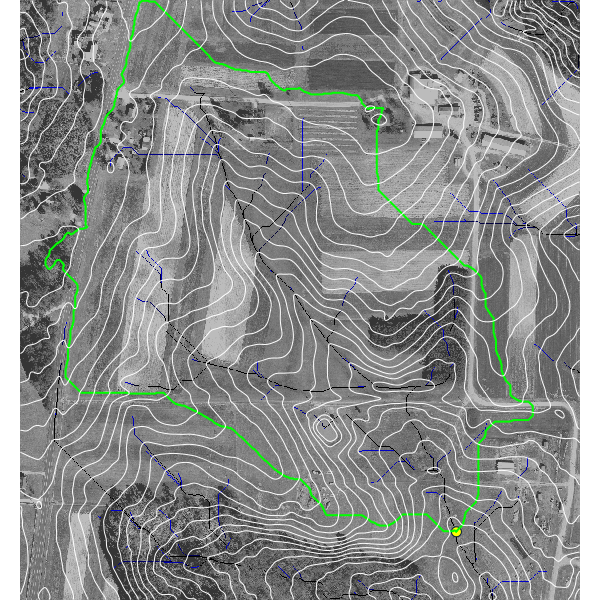

In [73]:
# Create Map instance
accum_5K_map = gj.Map(height=600, width=600, use_region=True, filename="output/watershedA30.png")
# Add the elevation raster to the map
accum_5K_map.d_rast(map="ortho_2001_t792_1m")
accum_5K_map.d_rast(map="accum_5K", values="1500-1000000")
accum_5K_map.d_vect(map="outletA30", fill_color="yellow", type="point", icon="basic/circle", size=10)
accum_5K_map.d_vect(map="basin_A30", color="green", type="boundary",width=2)
accum_5K_map.d_vect(map="elev_lid792_cont_1m", color="white")
accum_5K_map.show()

Compute the watershed area (category 1)

In [74]:
%%bash
r.report basin_A30 unit=h,a

+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: nc_spm_08_grass7                           Wed Apr 17 03:27:26 2024|
|-----------------------------------------------------------------------------|
|          north: 220750    east: 639000                                      |
|REGION    south: 220000    west: 638300                                      |
|          res:        1    res:       1                                      |
|-----------------------------------------------------------------------------|
|MASK: none                                                                   |
|-----------------------------------------------------------------------------|
|MAP: Watershed basin (basin_A30 in HW_7A_Flow_Modeling)                      |
|-----------------------------------------------------------------------------|
|                 Category Information  

   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  60%  63%  66%  69%  72%  75%  78%  81%  84%  87%  90%  93%  96%  99% 100%


<div class="alert alert-block alert-info">

### Question: What is the area of the watershed?

The area of the watershed is 55.455 acres

## Assess and mitigate impact of the road on flowrouting

Compare the extracted streams (accum > 1500) with official stream data:

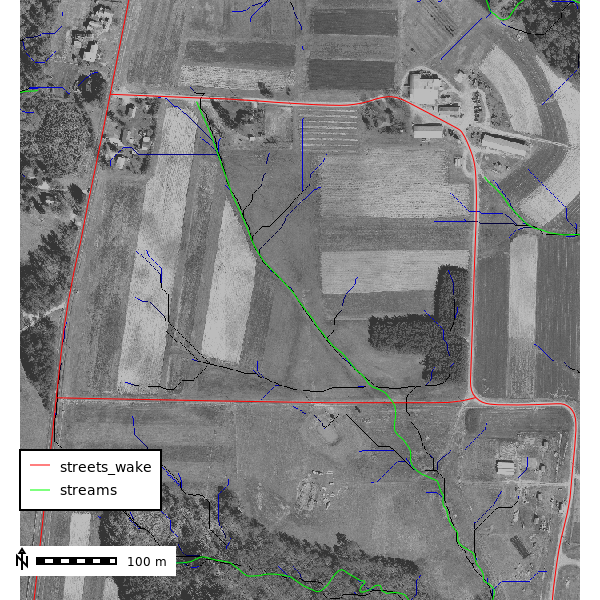

In [76]:
# Create Map instance
streamcompare_map = gj.Map(height=600, width=600, use_region=True, filename="output/streamcompare.png")

# Add raster layers
streamcompare_map.d_rast(map="ortho_2001_t792_1m")
streamcompare_map.d_rast(map="accum_5K", values="1500-1000000") # accum > 1500

# Add vector layersfound
streamcompare_map.d_vect(map="streets_wake", color="red")
streamcompare_map.d_vect(map="streams", color="green")

# Add map properties
streamcompare_map.d_legend_vect(at=[5,25], flags="b")
streamcompare_map.d_barscale(at=[2,9], flags="n")

# Display map
streamcompare_map.show()

Carve a pre-defined channel given by the stream data into DEM

In [77]:
%%bash
r.carve raster=elev_lid792_1m vector=streams width=2 depth=0.8 output=elev_lidcarved_1m
r.colors elev_lidcarved_1m raster=elev_lid792_1m

Reading raster map...
  10%  21%  32%  43%  54%  65%  76%  87%  98% 100%
Processing lines...
  10%  21%  32%  43%  54%  65%  76%WARNING: Vect runs out of region and re-enters - this case is not yet
         implemented.
  87%  98% 100%
Writing raster map...
   0%  11%  22%  33%  44%  55%  66%  77%  88%  99%Color table for raster map <elev_lidcarved_1m> set to 'elev_lid792_1m'


Display carved DEM

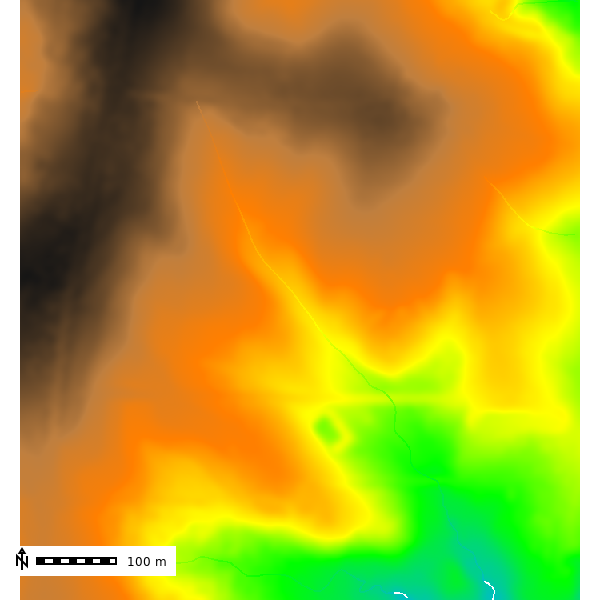

In [78]:
# Create Map instance
elev_lidcarved_1m_map = gj.Map(height=600, width=600, use_region=True)

# Add raster layers
elev_lidcarved_1m_map.d_rast(map="elev_lidcarved_1m")

# Add map properties
elev_lidcarved_1m_map.d_barscale(at=[2,9], flags="n")

# Display map
elev_lidcarved_1m_map.show()

Extract streams from the carved DEM and compare with the official streams map.

In [79]:
%%bash
r.watershed -as elevation=elev_lidcarved_1m accumulation=accumc_5K1m --quiet

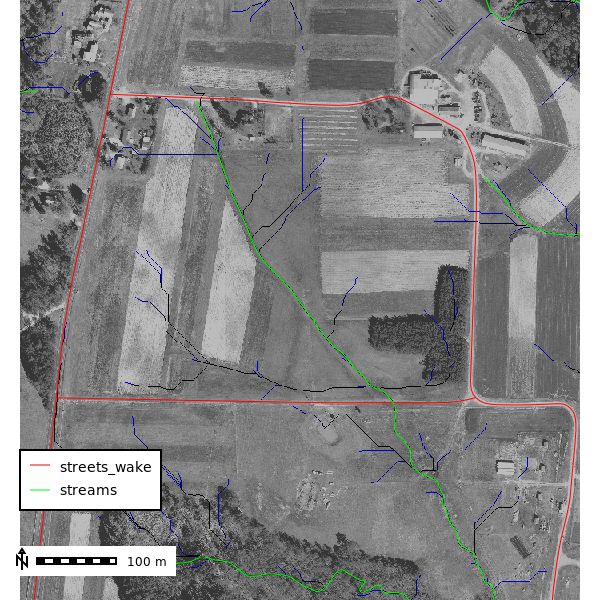

In [80]:
# Create Map instance
streamcarved_map = gj.Map(height=600, width=600, use_region=True, filename="output/streamcarved.png")

# Add raster layers
streamcarved_map.d_rast(map="ortho_2001_t792_1m")
#streamcarved_map.d_rast(map="accum_5K", values="1500-1000000") # accum > 1500
streamcarved_map.d_rast(map="accumc_5K1m", values="1500-1000000") # accum > 1500

# Add vector layers
streamcarved_map.d_vect(map="streets_wake", color="red")
streamcarved_map.d_vect(map="streams", color="green")

# Add map properties
streamcarved_map.d_legend_vect(at=[5,25], flags="b")
streamcarved_map.d_barscale(at=[2,9], flags="n")

# Display map
streamcarved_map.show()

<div class="alert alert-block alert-info">

## Question: What is the difference between accum_5K, accumc_5K1m and streams?

The accum_5K map uses a least cost path for depressions, whereas the accumc_51K map was derived from a carved DEM. The accum_5K map also takes into consideration an outlet point. The official streams has a lot less detail compared to the other two.

<div class="alert alert-block alert-info">

## Question: Explain the advantage and disadvantage of carving.

A disadvantage of carving is that it can create potential artifacts if these digitized streams dont match up with the DEM. Carving is helpful when it comes to getting rid of flat areas.

## Compute refined flow pattern using D-inf

Compare upslope and downslope flow lines:

In [81]:
%%bash
g.region raster=elev_lid792_1m -p
r.flow elevation=elev_lid792_1m flowline=flowlines flowlength=flowlg_1m flowaccumulation=flowacc_1m
r.flow -u elevation=elev_lid792_1m flowlength=flowlgup_1m flowaccumulation=flowaccup_1m

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


Reading input raster map <elev_lid792_1m>...
   0%   6%  12%  18%  24%  30%  36%  42%  48%  54%  60%  66%  72%  78%  84%  90%  96% 100%
Calculating...
   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  60%  63%  66%  69%  72%  75%  78%  81%  84%  87%  90%  93%  96%  99% 100%
Writing output raster map <flowacc_1m>...
   0%   6%  12%  18%  24%  30%  36%  42%  48%  54%  60%  66%  72%  78%  84%  90%  96% 100%
Building topology for vector map <flowlines@HW_7A_Flow_Modeling>...
Registering primitives...
Reading input raster map <elev_lid792_1m>...
   0%   6%  12%  18%  24%

Display maps along with contours to see relation to terrain:

Display the downslope flowlines.

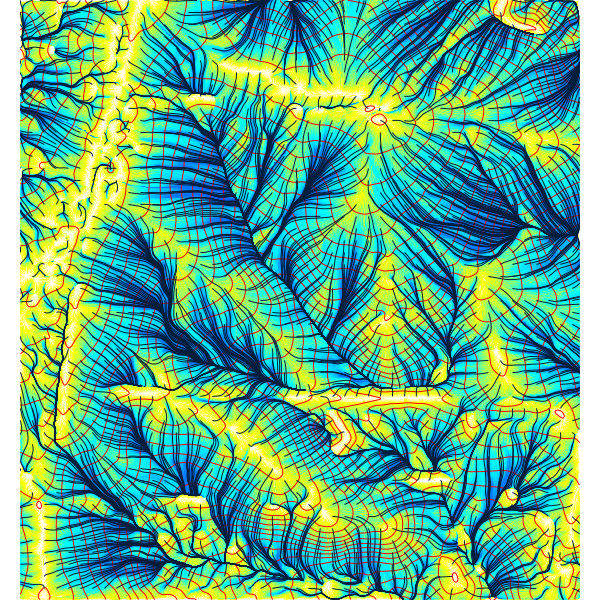

In [82]:
# Create Map instance
flowdown_map = gj.Map(height=600, width=600, filename="output/flowdown.png")\

flowdown_map.d_rast(map="flowacc_1m")
flowdown_map.d_vect(map="elev_lid792_cont_1m", color="red")
flowdown_map.d_vect(map="flowlines")

# Display map
flowdown_map.show()

Display the upslope flowlines

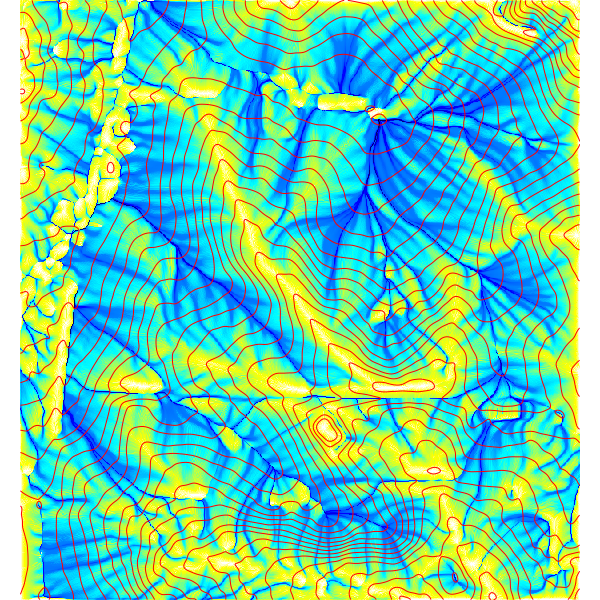

In [83]:
flowlines_map = gj.Map(height=600, width=600, filename="output/flowlines.png")\

flowlines_map.d_rast(map="flowaccup_1m")
flowlines_map.d_vect(map="elev_lid792_cont_1m", color="red")

# Display map
flowlines_map.show()

<div class="alert alert-block alert-info">

### Question: On what type of landform (ridge, valley) they converge?

The flowlines converge on ridges.

## Compare the multiple flow direction result with D8 and Dinf

In [84]:
%%bash
r.watershed -a elevation=elev_lid792_1m threshold=5000 accumulation=accum_mfd_5K1m --quiet

Display multiple flow direction.

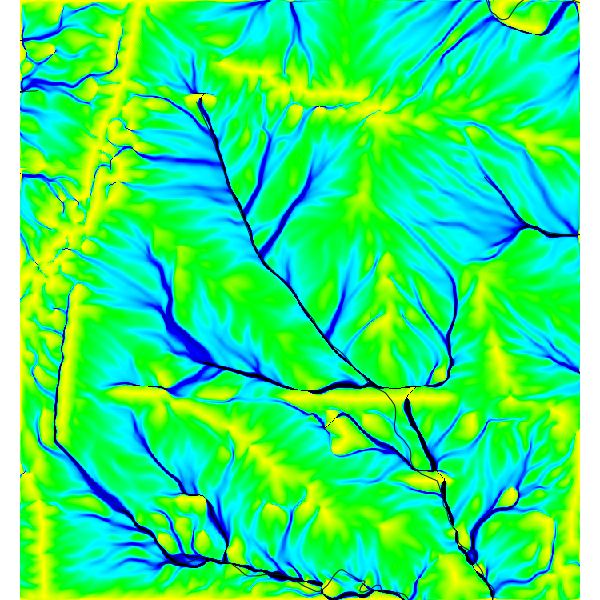

In [85]:
# Create Map instance
stream_mfd_map = gj.Map(height=600, width=600, filename="output/stream_mfd.png")
stream_mfd_map.d_rast(map="accum_mfd_5K1m")
stream_mfd_map.d_vect(map="streams")

# Display map
stream_mfd_map.show()

Display single flow direction

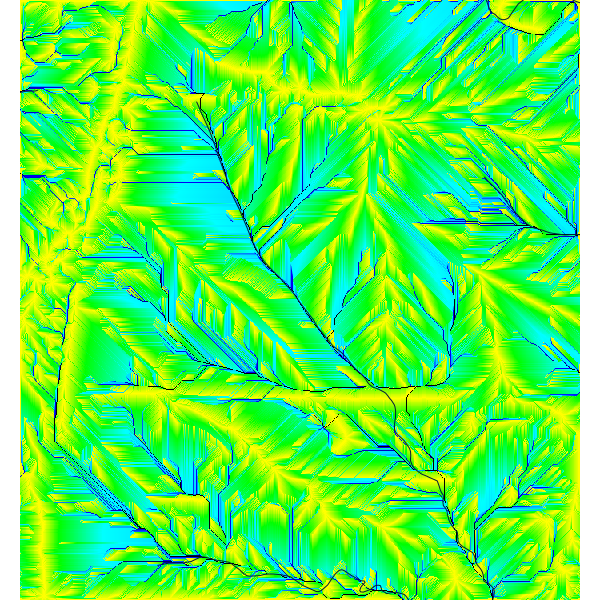

In [86]:
# Create Map instance
stream_sfd_map = gj.Map(height=600, width=600, filename="output/stream_sfd.png")\

stream_sfd_map.d_rast(map="accum_5K")
stream_sfd_map.d_vect(map="streams")

# Display map
stream_sfd_map.show()

<div class="alert alert-block alert-info">

### Question: Compare the results of r.watershed: accum_5K and accum_mfd_5K1m. Why are they different, which is more accurate and why?

The accum_5K map uses single flow direction, meaning only one downslope direction is used. In the accum_mfd_5K1m map, multiple flow directions are used. Since more than one flow direction is used, it results in higher accuracy since there is not only a single direction of movement.

## Compute wetness index

In [87]:
%%bash
g.region rural_1m -p
r.topidx elev_lid792_1m output=wetness_1m
r.colors map=wetness_1m color=water

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


Reading elevation map...
   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  60%  63%  66%  69%  72%  75%  78%  81%  84%  87%  90%  93%  96%  99% 100%
Calculating...
   0%   2%   4%   6%   8%  10%  12%  14%  16%  18%  20%  22%  24%  26%  28%  30%  32%  34%  36%  38%  40%  42%  44%  46%  48%  50%  52%  54%  56%  58%  60%  62%  64%  66%  68%  70%  72%  74%  76%  78%  80%  82%  84%  86%  88%  90%  92%  94%  96%  98% 100%
Number of sinks or boundaries: 53
Writing topographic index map...
   0%   3%   6% 

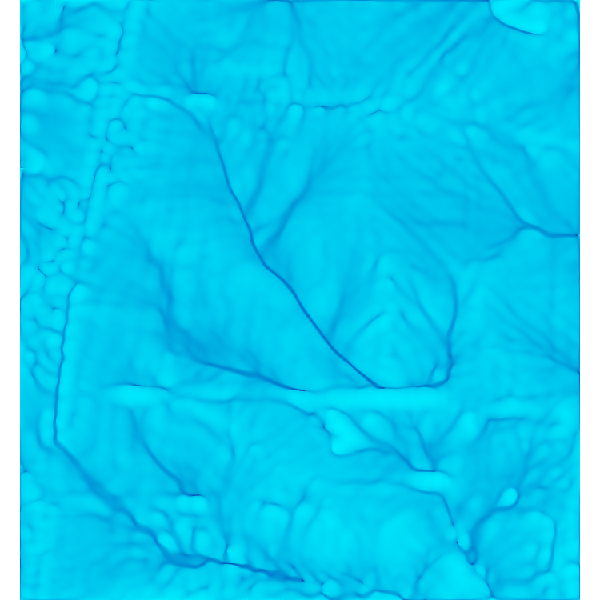

In [88]:
# Create Map instance
wetness_map = gj.Map(height=600, width=600, filename="output/wetness.png")
wetness_map.d_rast(map="wetness_1m")

wetness_map.show()

Display `elev_lid792_1m` in 3D and drape over `wetness_1m` as color.\
Note: switch off all layers except for elev_lid792_1m

> Google Colab Note: This step will fail when run with Google Colab.
Skip to next cell.

In [37]:
# elevation_3dmap = gj.Map3D(filename="output/3dWetnessIndex.png")
# Full list of options m.nviz.image
# https://grass.osgeo.org/grass83/manuals/m.nviz.image.html
# elevation_3dmap.render(
    # elevation_map="elev_lid792_1m",
    # color_map="wetness_1m",
    # perspective=20,
    # height=3000,
    # vline="streams",
    # vline_color="blue",
    # vpoint="usgsgages",
    # vpoint_color="red",
    # vpoint_marker="sphere",
   # vpoint_size=200,
    # fringe=['ne','nw','sw','se'],
    # arrow_position=[100,50],
# )
# elevation_3dmap.overlay.d_legend(raster="wetness_1m", at=(60, 97, 87, 92))
# elevation_3dmap.overlay.d_barscale(at=(60, 97, 87, 92))

# elevation_3dmap.show()

**Compute the wettness index using the formula in the lecture**

> hint: you will need to compute slope using `elev_lid792_1m` and use `accum_mfd_5K1m` as contributing area.

Check the values by comparing your output with wetness_1m computed with r.topidx.

[r.topidx](https://grass.osgeo.org/grass83/manuals/r.topidx.html) creates topographic index (wetness index), ln(a/tan(beta)), map from elevation map

where
```
    a: the area of the hillslope per unit contour length that drains through any point,

    tan(beta): the local surface topographic slope (delta vertical) / (delta horizontal).
```

<div class="alert alert-block alert-info">

### Task: Compute and Compare Wetness Indices

In [108]:
%%bash

r.slope.aspect elevation=elev_lid792_1m slope=slope_1m aspect=aspect_1m

r.mapcalc "wet = ln(accum_mfd_5K1m) / (tan(slope_1m))" # * pow(sin(slope_1m)/0.09,1.0)"

r.colors map=wet color=water

   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  60%  63%  66%  69%  72%  75%  78%  81%  84%  87%  90%  93%  96%  99% 100%
Aspect raster map <aspect_1m> complete
Slope raster map <slope_1m> complete
Undefined function 'ln'
Parse error
ERROR: parse error
Color table for raster map <wet> set to 'water'


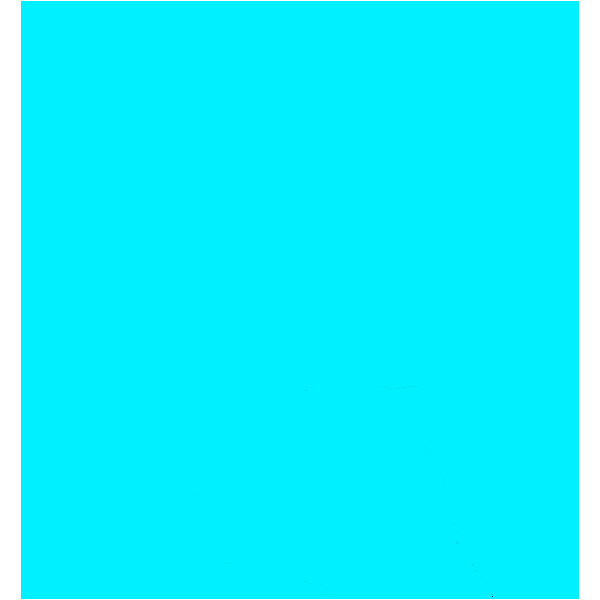

In [109]:
# Create Map instance
wetness_map2 = gj.Map(height=600, width=600, filename="output/wet.png")
wetness_map2.d_rast(map="wet")

wetness_map2.show()

## Create a map of flooded area

Create a map of flooded area for a given water level and seed point:

In [90]:
%%bash
r.lake elevation=elev_lid792_1m water_level=113.5 lake=flood1 coordinates=638728,220278

   5%  11%  17%  23%  29%  35%  41%  47%  53%  59%  65%  71%  77%  83%  89%  95% 100%
 100%
   5%  11%  17%  23%  29%  35%  41%  47%  53%  59%  65%  71%  77%  83%  89%  95% 100%
Lake depth from 0.000000 to 0.860382 (specified water level is taken as
zero)
Lake area 2245.000000 square meters
Lake volume 891.858521 cubic meters
Volume is correct only if lake depth (terrain raster map) is in meters


Display flooded area

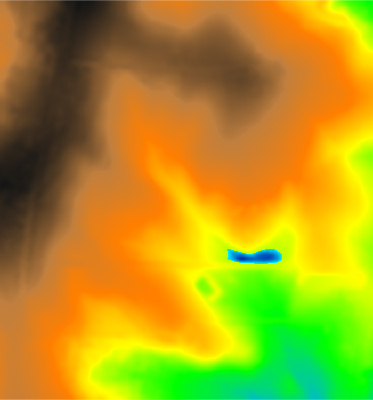

In [91]:
# Create Map instance
floodedarea_map = gj.Map(filename="output/floodedarea.png")

floodedarea_map.d_rast(map="elev_lid792_1m")
floodedarea_map.d_rast(map="flood1")

# Display map
floodedarea_map.show()

<div class="alert alert-block alert-info">

### Task: Increase water level to 113.7m and 115.0m and create flooded area maps at these two levels. Include the maps of flooded areas at these water levels in your report.

In [46]:
## Flood level 113.7

%%bash
r.lake elevation=elev_lid792_1m water_level=113.7 lake=flood37 coordinates=638728,220278

   5%  11%  17%  23%  29%  35%  41%  47%  53%  59%  65%  71%  77%  83%  89%  95% 100%
 100%
   5%  11%  17%  23%  29%  35%  41%  47%  53%  59%  65%  71%  77%  83%  89%  95% 100%
Lake depth from 0.000000 to 9.935738 (specified water level is taken as
zero)
Lake area 81918.000000 square meters
Lake volume 295516.979782 cubic meters
Volume is correct only if lake depth (terrain raster map) is in meters


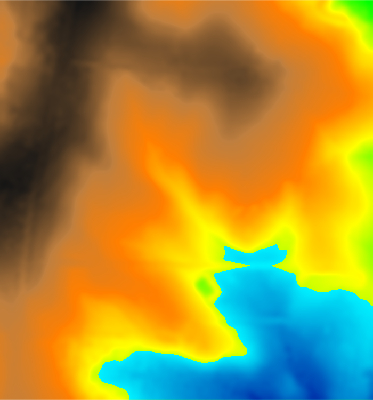

In [47]:
# Create Map instance
floodedarea_map37 = gj.Map(filename="output/floodedarea37.png")

floodedarea_map37.d_rast(map="elev_lid792_1m")
floodedarea_map37.d_rast(map="flood37")

# Display map
floodedarea_map37.show()

In [48]:
## Flood level 115.0

%%bash
r.lake elevation=elev_lid792_1m water_level=115.0 lake=flood50 coordinates=638728,220278

   5%  11%  17%  23%  29%  35%  41%  47%  53%  59%  65%  71%  77%  83%  89%  95% 100%
 100%
   5%  11%  17%  23%  29%  35%  41%  47%  53%  59%  65%  71%  77%  83%  89%  95% 100%
Lake depth from 0.000000 to 11.235741 (specified water level is taken as
zero)
Lake area 112176.000000 square meters
Lake volume 425847.237419 cubic meters
Volume is correct only if lake depth (terrain raster map) is in meters


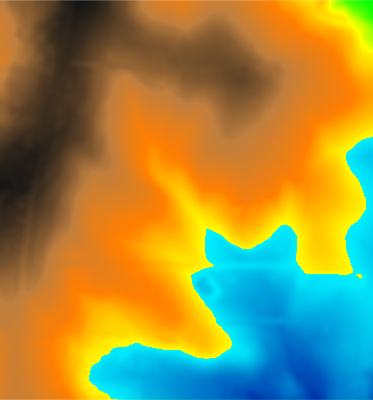

In [49]:
# Create Map instance
floodedarea_map50 = gj.Map(filename="output/floodedarea50.png")

floodedarea_map50.d_rast(map="elev_lid792_1m")
floodedarea_map50.d_rast(map="flood50")

# Display map
floodedarea_map50.show()